<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load from database

In [2]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATABASE_DUMP_FILE = 'gs://roft_buckups/09/23/2021.json'

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    db = json.load(f)

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [5]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'core.decodingstrategy', 'auth.permission', 'core.system', 'auth.user', 'core.prompt', 'core.profile', 'core.feedbackoption', 'core.annotation', 'core.dataset', 'core.playlist', 'sessions.session', 'contenttypes.contenttype', 'core.timestamp', 'core.generation', 'admin.logentry'}


### Load all the tables

In [8]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [9]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [10]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [11]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')

In [12]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

In [13]:
full_df

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,playlist_name,playlist_version
0,2021-06-12 22:17:41.178000+00:00,2,909,1,3,0,False,[],1,gpt2,932,1,Jack and Max was a fine company to join on suc...,"It's lonely work, killing the future._SEP_Jack...",5,1,1653,top-p,0.4,Short Stories,0.2
1,2021-06-12 23:08:41.084000+00:00,4,909,1,3,0,False,[contradicts_knowledge],2,gpt2,932,1,Jack and Max was a fine company to join on suc...,"It's lonely work, killing the future._SEP_Jack...",5,1,1653,top-p,0.4,Short Stories,0.2
2,2021-06-21 19:31:08.098000+00:00,139,18298,3,0,0,False,[contradicts_knowledge],3,ctrl,13345,1,,"""Speech on Foreign Policy"" by President Ronald...",10,8,714,top-p,0.4,Presidential Speeches,0.2
3,2021-06-23 19:35:29.878000+00:00,182,18298,3,0,0,False,[-2311780724603632545],4,ctrl,13345,1,,"""Speech on Foreign Policy"" by President Ronald...",10,8,714,top-p,0.4,Presidential Speeches,0.2
4,2021-06-25 18:56:37.169000+00:00,272,12621,-1,7,0,False,[irrelevant],5,gpt2-xl,7668,4,The Mayor has been in office for more than two...,"USUALLY, when a mayor dismisses people from th...",9,3,1098,top-p,0.2,New York Times,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15333,2021-09-14 14:36:06.665000+00:00,2764,18284,7,3,0,False,[],19306,ctrl,13331,1,"And when they say the President, they're talki...","""University of Notre Dame Commencement"" by Pre...",9,8,674,top-p,0.4,Presidential Speeches,0.2
15334,2021-09-14 14:36:14.091000+00:00,2764,18178,7,2,5,False,[],19307,ctrl,13225,1,"And thank you, Speaker Pelosi, for leading the...","""Victims Rights Announcement"" by President Bil...",3,8,200,top-p,0.4,Presidential Speeches,0.2
15335,2021-09-14 14:36:30.688000+00:00,2764,18327,7,4,5,False,[],19308,ctrl,13374,1,Your financial standing has been so well estab...,"""Address to the American Bankers’ Association....",5,6,40,top-p,0.4,Presidential Speeches,0.2
15336,2021-09-14 14:37:51.209000+00:00,2764,18236,7,9,1,False,[],19309,ctrl,13283,1,Our current methods for producing oil are unsu...,"""Address to the Nation on Energy"" by President...",6,8,460,top-p,0.4,Presidential Speeches,0.2


# Analysis

## Mean points

In [ ]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  for playlist in playlist_names:
    df = full_df[(full_df["playlist_name"]==playlist) & (full_df["playlist_version"]=="0.2")]

    info = {"playlist": playlist,
            "mean score": np.mean(df["points"]),
            "median score": np.median(df["points"]),
            "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
            "num_annotations": len(df)
    }
    info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,mean score,median score,fraction_nonzero,num_annotations
0,Short Stories,2.335368,2.0,0.565326,3605
1,Presidential Speeches,1.843945,1.0,0.515605,2403
2,New York Times,1.718878,0.0,0.484610,2924
3,Recipes,1.959184,0.0,0.484067,5586


In [ ]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  for playlist in playlist_names:
    for top_p_value in [0.0, 0.4, 1.0]:
      df = full_df[(full_df["dec_strat"]=="top-p") &
                  (full_df["dec_strat_value"]==top_p_value) &
                  (full_df["playlist_name"]==playlist)]

      if len(df) > 0:
        info = {"p-value": top_p_value,
                "playlist": playlist,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df),
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_decoding_strat()

,p-value,playlist,mean score,median score,fraction_nonzero,num_annotations
0,0.0,Short Stories,1.551887,0.0,0.466981,212
1,0.4,Short Stories,2.412543,3.0,0.573905,3173
2,1.0,Short Stories,1.977273,2.0,0.536364,220
3,0.4,Presidential Speeches,1.843945,1.0,0.515605,2403
4,0.0,New York Times,1.523153,0.0,0.456158,1015
5,0.4,New York Times,1.584430,0.0,0.455044,912
6,1.0,New York Times,2.041123,1.0,0.540622,997
7,0.4,Recipes,1.959184,0.0,0.484067,5586


In [ ]:
full_df.columns

Index(['date', 'annotator', 'generation', 'playlist', 'boundary', 'points',
       'attention_check', 'reason', 'pk', 'system', 'prompt',
       'decoding_strategy', 'gen_body', 'prompt_body', 'num_sentences',
       'dataset', 'prompt_index', 'dec_strat', 'dec_strat_value',
       'playlist_name', 'playlist_version'],
      dtype='object')

In [ ]:
[0.0, 0.4, 1.0]

## Annotator skill

<AxesSubplot:title={'center':'Achieved Points Distribution'}, ylabel='Frequency'>

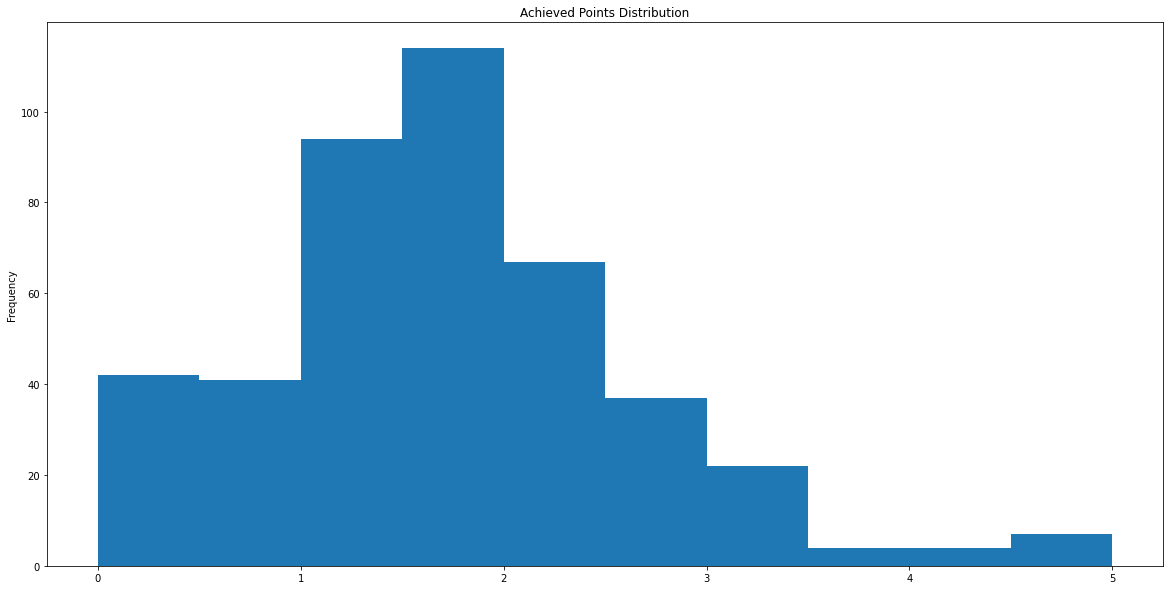

In [ ]:
annotation_df.groupby('annotator').points.mean().plot.hist(
    figsize=(20, 10),
    title='Achieved Points Distribution'
)

Of the annotators who did at least K annotations, plot their mean score over time

In [ ]:
df = annotation_df.groupby('annotator').count()


(100,)


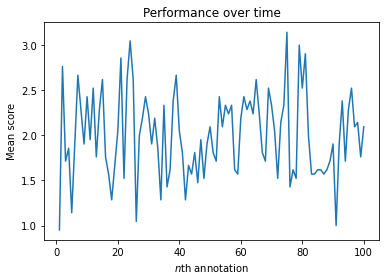

In [ ]:
def analyze_progress(k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  data = np.array(s)
  data = np.mean(data, axis=0)
  plt.plot(range(1, k+1), data)
  plt.ylabel("Mean score")
  plt.xlabel("$n$th annotation")
  plt.title("Performance over time")
  plt.show()

  return np.array(all_score_series)

k = 100
s = analyze_progress(k)

### Inter-annotator agreement

For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [14]:
annotations_per_gen = annotation_df.groupby('generation')
# 
num_annotations_per_gen = annotations_per_gen.points.count()


In [23]:
def analyze_fraction_agreements():
  generation_ids = set(annotation_df["generation"].tolist())
  annotations_per_gen = annotation_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.boundary.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 14359 total annotations on generations with >1 annotation, 6748 were in agreement with another annotation on the true boundary position. That is 0.46994916080507


In [ ]:
user_df[user_df["pk"] == 2697]

,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined,groups,user_permissions,pk
2696,pbkdf2_sha256$180000$hp9YfmKe5tvv$eoUGPhGpjKz7...,2021-09-08T21:35:40.375Z,False,xyc,,,,False,True,2021-09-08T20:58:58.557Z,[],[],2697


## Profile Statistics

In [ ]:
profile_df.is_temporary.mean()

0.8858729179518815